# Lab5 Final assignment: putting it all together

The final assignment is an individual assignment in which you put things together. You earn 6 points when you carry out the basic tasks and an additional 4 points for analysing and discussing the results poperly. The maximum score is 10 points.

<ol>
    <li><b>Annotated Eliza conversations</b> [2 Points]
        <ul>
        <li> Load the annotated Eliza conversations in a Pandas data frame (code is given)
        <li>  Provide a statistical analysis of the emotion labels in the data
        </ul>
    <li><b>GO-emotions</b> [2 points]
        <ul>
        <li> Create a pipeline for the GO-emotion classifier
        <li> Apply the pipeline to the turns in the conversation
        <li> Map the GO labels to Ekman labels using a motivated(!) threshold
        <li> Generate a classification report and confusion matrix as evaluation
        </ul>
    <li><b>Train a BoW SVM Ekman emotion classifier combining both the MELD and Tweet data</b> [2 POINTS]
        <ul>
        <li> Load the train, test and development data from MELD and WASSA
        <li> Discuss the statistics of the training data for the Ekman emotions
        <li> Create a BoW vector representation and train an SVM classifier
        <li> Save the classifier to disk
        <li> Load the classifier in this notebook and apply it to the Eliza utterances
        <li> Generate a classification report and confusion matrix as evaluation
        </ul>
    <li><b>Discuss the result</b> [4 POINTS]
        <ul>
        <li> Report on similarities and differences in performances and confusion matrixes 
        <li> What did you expect (recall and precision) and is this confirmed or falsified?
        <li> An error analysis of a manual selection of 10-20 utterances [motivate your selection]?
        <li> Discuss how you could improve the SVM classification
        </ul>    
</ol>

For 3.), you build a BoW SVM classifier in a separate notebook (use **lab5.meld-tweet-bow-svm-emotion-classifier.ipynb**) to combine the MELD and Tweet data into a single set of training data. Note that you can also include the test and development data for training since we are applying the model to the Eliza conversations and not to the MELD and Wassa tests. 

## 1. Submission

The assignment should be made individually and submited on CANVAS as a zip file that includes the following:

   1. The notebook to create a BoW-SVM combining MELD and Tweets for Ekman classification: **lab5.meld-tweet-bow-svm-emotion-classifier.ipynb**
   2. The current notebook **lab5.final_assignment.ipynb** with your code
   3. A PDF report of max 5 pages:
       1. Section 1: what you have done and what choices did you make: be explicit about the settings and any data changes you made to train a classifier on MELD+Tweets
       2. Section 2: report on the Ekman classification results. Use a single table for recall, precision and f-score and put confusion matrixes in the appendix.
       3. Section 3: discuss the results comparing the SVM and the GO-classifier and the insights from your error analysis
       4. Section 4: how to improve the SVM classifier
    
Use the notebooks that are given as a guide with the code and the output. You should NOT discuss the results in the notebooks but in the report. Use the notebooks to run the experiments and get the results. Include the tables and figures in the report.

Some utility functions presented during this course are needed for this assignment. They are all included in the Python file **lab5_util.py**. The next import makes these functions available in this notebook. There is no need to copy these functions into this notebook explicitly. After the import, you can call the function from **util**, e.g.:

```emotion_labels = sort_predictions(emotion_labels[0])```

```ekman_labels = util.get_averaged_mapped_scores_by_threshold(ekman_map, emotion_labels, threshold)```

```util.plot_labels_with_counts(labels, values)```

In [1]:
import lab5_util as util
import pandas as pd
from collections import Counter, OrderedDict
from transformers import pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pickle
import sklearn
import numpy as np

## 2. Loading the conversation saved on disk

You receive a file with all the annoated conversations in CSV format. Load this file using Pandas to create a data frame.
The next code also applies the **get_test_utterances_and_labels** functions in util to extract from the dataframe the utterances and the Gold labels. It skips the utterances and labels from Eliza, which are all labeled as ```neutral```.


In [2]:
# THE CODE TO LOAD THE TEST DATA AND LABELS
file = "2022_2023_eliza.csv"
df = pd.read_csv(file, sep=";")
df = df.dropna()
# Filter out rows with 'Eliza' as the speaker
df = df[df['speaker'] != 'Eliza']
#Test instances and test labels
test_instances, test_labels = util.get_test_utterances_and_labels(df)
print(len(test_instances))
print(len(test_labels))
df.head()

2129
2129


,turn_id,utterance,speaker,Gold
0,1,I feel mad,speaker_1,anger
2,2,It's just numb and loneliness,speaker_1,sadness
4,3,My mom yells at me,speaker_1,fear
6,4,I'm surprised with the gift,speaker_1,surprise
8,5,I'm angry at you,speaker_1,anger


You have now an equal number of utterances and labels to test the classifiers.

### 1.2 Provide a statistical analysis of the test data

neutral: 833
joy: 343
sadness: 315
anger: 261
fear: 145
surprise: 125
disgust: 107
Total of values 2129


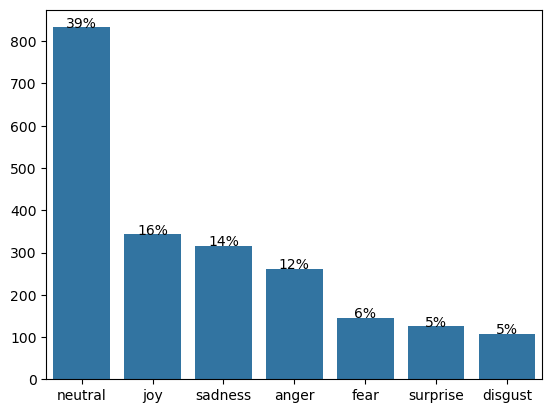

In [3]:
# [YOUR CODE FOR THE ANALYSIS GOES HERE]
counts = Counter(test_labels)
counts_sorted = OrderedDict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

for label, count in counts_sorted.items():
    print(f"{label}: {count}")

labels = list(counts_sorted.keys())
values = list(counts_sorted.values())
util.plot_labels_with_counts(labels, values)

## 2. Apply the GO classifier

In the next part, you will apply the GO_EMOTION classifier *emotion* to the conversation loaded in a Pandas frame. You will also map the GO_EMOTIONS to the 6 basic Ekman emotion and to neutral. For the mappings, we added the utility functions to **lab5_util.py** . We also define a sort function to list the emotions from the highest score down. You first need to haved imported **lab5_util** as decribed above.

## 2.1 Create a pipeline for the GO Classifier

In [40]:
# HERE COMES THE CODE TO CREATE A PIPELINE FOR THE BERT-BASE-GO-EMOTION classifier
model_name = "bhadresh-savani/bert-base-go-emotion" 
emotion_pipeline = pipeline('sentiment-analysis', model=model_name, top_k=None, truncation=True)

### 2.2 Apply the GO classifier pipeline to the conversation and convert the result to Ekman

In [46]:
threshold = 0.03

go_ekman_emotions = []
go_ekman_scores = []
go_emotions = []
go_scores = []

for utterance in test_instances:
    emotion_labels = emotion_pipeline(utterance)
    sorted_emotion_labels = util.sort_predictions(emotion_labels[0])
    go_emotions.append(sorted_emotion_labels[0]['label'])
    go_scores.append(sorted_emotion_labels[0]['score'])

    ekman_labels = util.get_averaged_mapped_scores_by_threshold(util.ekman_map, emotion_labels, threshold)
    if ekman_labels:
        go_ekman_emotions.append(ekman_labels[0]['label'])
        go_ekman_scores.append(ekman_labels[0]['score'])
    else:
        #### none of the labels scored above the threshold
        go_ekman_emotions.append('None')
        go_ekman_scores.append(0)

In [47]:
df['Go_Ekman']=go_ekman_emotions
df['Go_EkmanScore']=go_ekman_scores
df['Go']=go_emotions
df['GoScore']=go_scores
df.head()

,turn_id,utterance,speaker,Gold,Go_Ekman,Go_EkmanScore,Go,GoScore,SVM_Predictions
0,1,I feel mad,speaker_1,anger,neutral,0.177434,neutral,0.177434,anger
2,2,It's just numb and loneliness,speaker_1,sadness,fear,0.200018,fear,0.313251,neutral
4,3,My mom yells at me,speaker_1,fear,neutral,0.474732,neutral,0.474732,anger
6,4,I'm surprised with the gift,speaker_1,surprise,surprise,0.832211,surprise,0.832211,neutral
8,5,I'm angry at you,speaker_1,anger,anger,0.419512,anger,0.770886,anger


## 2.3 Evaluation

In [48]:
# HERE COMES THE CODE TO GENERATE THE CLASSIFICATION REPORT AND CONFUSION MATRIX
predictions = df['Go_Ekman']
labels = list(test_labels)+list(predictions)
label_set = sorted(set(labels))
print(label_set)

['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']


In [49]:

predictions = df['Go_Ekman']
report = classification_report(test_labels, predictions, digits = 7, target_names=label_set)
print('GO EKMAN mapping ----------------------------------------------------------------')
print('Mapping threshold', threshold)
print(report)

GO EKMAN mapping ----------------------------------------------------------------
Mapping threshold 0.03
              precision    recall  f1-score   support

       anger  0.6060606 0.4597701 0.5228758       261
     disgust  0.6956522 0.2990654 0.4183007       107
        fear  0.8453608 0.5655172 0.6776860       145
         joy  0.5910165 0.7288630 0.6527415       343
     neutral  0.6187683 0.7599040 0.6821121       833
     sadness  0.7971014 0.5238095 0.6321839       315
    surprise  0.5259259 0.5680000 0.5461538       125

    accuracy                      0.6355096      2129
   macro avg  0.6685551 0.5578470 0.5902934      2129
weighted avg  0.6529706 0.6355096 0.6289291      2129



Confusion matrix SVM
[[120   4   1  11 105   7  13]
 [ 19  32   2   6  37   9   2]
 [  7   1  82   6  42   5   2]
 [  1   2   1 250  81   4   4]
 [ 31   3   7 111 633  14  34]
 [ 18   4   4  30  85 165   9]
 [  2   0   0   9  40   3  71]]


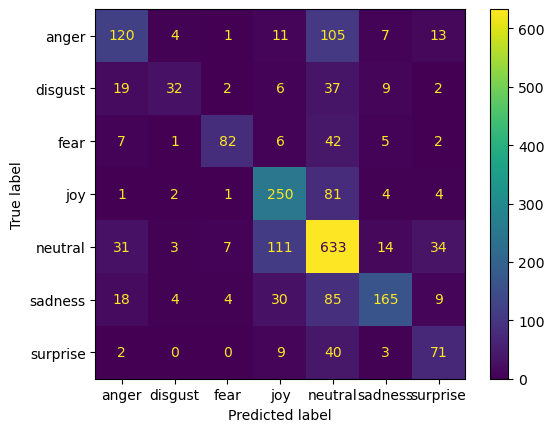

In [50]:
print('Confusion matrix SVM')
cf_matrix = confusion_matrix(test_labels,predictions)
print(cf_matrix)
display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=label_set)
display.plot()

## 3 Apply the BoW classifier

### 3.1 Load the BoW SVM classifier from MELD and TWEETS

In [33]:
# HERE COMES THE CODE TO LOAD THE BOW SVM CLASSIFIER BUILT FROM MELD AND WASSA TWEETS
filename_vectorizer = './models/combined_vectorizer.sav'
filename_tfidftransformer = './models/combined_tfidf_transformer.sav'
filename_classifier = './models/svm_linear_clf_bow.sav'

loaded_vectorizer = pickle.load(open(filename_vectorizer, 'rb'))
loaded_tfidftransformer = pickle.load(open(filename_tfidftransformer, 'rb'))
loaded_classifier = pickle.load(open(filename_classifier, 'rb'))


### 3.2 Apply the classifier to the conversation

In [34]:
# HERE COMES THE CODE TO APPLY THE CLASSIFIER TO THE UTTERANCES
print(len(test_instances))
print(len(test_labels))

new_counts = loaded_vectorizer.transform(test_instances)
new_tfidf = loaded_tfidftransformer.transform(new_counts)
new_tfidf.shape


2129
2129


(2129, 3616)

In [35]:
new_predictions = loaded_classifier.predict(new_tfidf)
for utterance, predicted_label in zip(test_instances[:20], new_predictions[:20]):
    print('%s => %s' % (utterance, predicted_label))

I feel mad => anger
It's just numb and loneliness => neutral
My mom yells at me => anger
I'm surprised with the gift => neutral
I'm angry at you => anger
I'm very frustrated => joy
The food looks disgusting => disgust
I feel happy again => joy
I want to laugh a lot with my family => joy
I'm sad thinking about the past => sadness
I care about you => neutral
It makes me numb => joy
I'm very frustrated with the administration => neutral
I don't have any friends => neutral
I want to go to a park sometimes => neutral
But now I'm hungry => neutral
I feel confused often => sadness
I don't want to tell you at all => neutral
I'm shocked he's single => sadness
I have two apples and I feel angry => anger


## 3.3 Evaluation

In [36]:
# HERE COMES THE CODE TO GENERATE THE CLASSIFICATION REPORT AND CONFUSION MATRIX
frequency_threshold = 3
report = classification_report(test_labels, new_predictions, digits = 7)
print('LOADED CLASSIFIER RESULTS, BoW TFIDF SVM LINEAR ---------------')
print('Word freqeuncy threshold:', frequency_threshold)
print(report)

LOADED CLASSIFIER RESULTS, BoW TFIDF SVM LINEAR ---------------
Word freqeuncy threshold: 3
              precision    recall  f1-score   support

       anger  0.4331984 0.4099617 0.4212598       261
     disgust  0.3800000 0.1775701 0.2420382       107
        fear  0.5564516 0.4758621 0.5130112       145
         joy  0.5987461 0.5568513 0.5770393       343
     neutral  0.5716862 0.7611044 0.6529351       833
     sadness  0.6055046 0.4190476 0.4953096       315
    surprise  0.3387097 0.1680000 0.2245989       125

    accuracy                      0.5509629      2129
   macro avg  0.4977566 0.4240567 0.4465989      2129
weighted avg  0.5397217 0.5509629 0.5336545      2129



LOADED CLASSIFIER RESULTS, Confusion matrix SVM ---------
['anger' 'disgust' 'fear' 'joy' 'neutral' 'sadness' 'surprise']
[[107  12   4  14 106   7  11]
 [ 10  19   5   7  59   6   1]
 [ 15   0  69   5  42  12   2]
 [ 22   2   7 191 105  13   3]
 [ 64   3  22  50 634  38  22]
 [ 18   2  11  37 113 132   2]
 [ 11  12   6  15  50  10  21]]


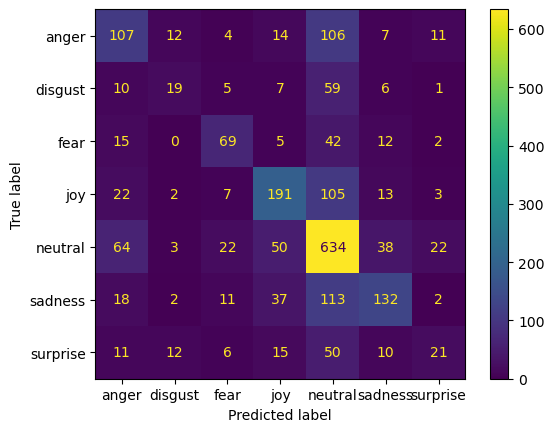

In [37]:
print('LOADED CLASSIFIER RESULTS, Confusion matrix SVM ---------')
print(loaded_classifier.classes_)
cf_matrix_svm = sklearn.metrics.confusion_matrix(test_labels, new_predictions)
print(cf_matrix_svm)
display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix_svm, display_labels=loaded_classifier.classes_)
display.plot()

### Comparative performance analysis

In [20]:
# Comparing the precision, recall, and F1-score for each emotion
go_precision = [0.6060606, 0.6956522, 0.8453608, 0.5910165, 0.6187683, 0.7971014, 0.5259259]
go_recall = [0.4597701, 0.2990654, 0.5655172, 0.7288630, 0.7599040, 0.5238095, 0.5680000]
go_f1 = [0.5228758, 0.4183007, 0.6776860, 0.6527415, 0.6821121, 0.6321839, 0.5461538]

svm_precision = [0.4331984, 0.3800000, 0.5564516, 0.5987461, 0.5716862, 0.6055046, 0.3387097]
svm_recall = [0.4099617, 0.1775701, 0.4758621, 0.5568513, 0.7611044, 0.4190476, 0.1680000]
svm_f1 = [0.4212598, 0.2420382, 0.5130112, 0.5770393, 0.6529351, 0.4953096, 0.2245989]

emotions = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

# Calculate the absolute differences between GO and SVM classifiers for precision, recall, and F1-score
precision_diff = np.abs(np.array(go_precision) - np.array(svm_precision))
recall_diff = np.abs(np.array(go_recall) - np.array(svm_recall))
f1_diff = np.abs(np.array(go_f1) - np.array(svm_f1))

differences = {
    'Emotion': emotions,
    'Precision Difference': precision_diff,
    'Recall Difference': recall_diff,
    'F1-Score Difference': f1_diff}

differences_df = pd.DataFrame(differences)
print(differences_df)


    Emotion  Precision Difference  Recall Difference  F1-Score Difference
0     anger              0.172862           0.049808             0.101616
1   disgust              0.315652           0.121495             0.176263
2      fear              0.288909           0.089655             0.164675
3       joy              0.007730           0.172012             0.075702
4   neutral              0.047082           0.001200             0.029177
5   sadness              0.191597           0.104762             0.136874
6  surprise              0.187216           0.400000             0.321555


In [51]:
# Calculate the differences in accuracy, macro avg, and weighted avg
go_accuracy = 0.6355096
go_macro_precision = 0.6685551
go_macro_recall = 0.5578470
go_macro_f1 = 0.5902934
go_weighted_precision = 0.6529706
go_weighted_recall = 0.6355096
go_weighted_f1 = 0.6289291

svm_accuracy = 0.5509629
svm_macro_precision = 0.4977566
svm_macro_recall = 0.4240567
svm_macro_f1 = 0.4465989
svm_weighted_precision = 0.5397217
svm_weighted_recall = 0.5509629
svm_weighted_f1 = 0.5336545

accuracy_diff = abs(go_accuracy - svm_accuracy)
macro_precision_diff = abs(go_macro_precision - svm_macro_precision)
macro_recall_diff = abs(go_macro_recall - svm_macro_recall)
macro_f1_diff = abs(go_macro_f1 - svm_macro_f1)
weighted_precision_diff = abs(go_weighted_precision - svm_weighted_precision)
weighted_recall_diff = abs(go_weighted_recall - svm_weighted_recall)
weighted_f1_diff = abs(go_weighted_f1 - svm_weighted_f1)

differences_avg = {
    'Metric': ['Accuracy', 'Macro Avg Precision', 'Macro Avg Recall', 'Macro Avg F1-Score', 
               'Weighted Avg Precision', 'Weighted Avg Recall', 'Weighted Avg F1-Score'],
    'Difference': [accuracy_diff, macro_precision_diff, macro_recall_diff, macro_f1_diff,
                   weighted_precision_diff, weighted_recall_diff, weighted_f1_diff]}

differences_avg_df = pd.DataFrame(differences_avg)
print(differences_avg_df)

                   Metric  Difference
0                Accuracy    0.084547
1     Macro Avg Precision    0.170798
2        Macro Avg Recall    0.133790
3      Macro Avg F1-Score    0.143694
4  Weighted Avg Precision    0.113249
5     Weighted Avg Recall    0.084547
6   Weighted Avg F1-Score    0.095275


### Extracting test instances for error analysis

In [23]:
# Filter instances where the gold label is "disgust," the SVM classifier used any label other than "disgust,"
# but the GO classifier correctly labelled it as "disgust"
df['SVM_Predictions'] = new_predictions
disgust_svm_misclassified_go_disgust = df[(df['Gold'] == 'disgust') & (df['SVM_Predictions'] != 'disgust') & (df['Go_Ekman'] == 'disgust')]

instance_numbers = disgust_svm_misclassified_go_disgust['turn_id']
instances = disgust_svm_misclassified_go_disgust['utterance']
gold_labels = disgust_svm_misclassified_go_disgust['Gold']
go_ekman_predictions = disgust_svm_misclassified_go_disgust['Go_Ekman']
svm_predictions = disgust_svm_misclassified_go_disgust['SVM_Predictions']

#for instance_number, instance, gold_label, go_ekman_prediction, svm_prediction in zip(instance_numbers, instances, gold_labels, go_ekman_predictions, svm_predictions):
    #print(f"Instance Number: {instance_number}")
    #print(f"Instance: {instance}")
    #print(f"GOLD Label: {gold_label}")
    #print(f"GO Ekman Prediction: {go_ekman_prediction}")
    #print(f"SVM Prediction: {svm_prediction}")
    #print("\n")

In [24]:
# Filter instances where the gold label is "disgust" but neither classifier predicted "disgust"
disgust_errors = df[(df['Gold'] == 'disgust') & (df['Go_Ekman'] != 'disgust') & (df['SVM_Predictions'] != 'disgust')]

instance_numbers = disgust_errors['turn_id']
instances = disgust_errors['utterance']
gold_labels = disgust_errors['Gold']
go_ekman_predictions = disgust_errors['Go_Ekman']
svm_predictions = disgust_errors['SVM_Predictions']

#for instance_number, instance, gold_label, go_ekman_prediction, svm_prediction in zip(instance_numbers, instances, gold_labels, go_ekman_predictions, svm_predictions):
    #print(f"Instance Number: {instance_number}")
    #print(f"Instance: {instance}")
    #print(f"GOLD Label: {gold_label}")
    #print(f"GO Ekman Prediction: {go_ekman_prediction}")
    #print(f"SVM Prediction: {svm_prediction}")
    #print("\n")

In [25]:
# Filter instances where the gold label is "surprise," the SVM classifier used any label other than "surprise,"
# but the GO classifier correctly labelled it as "surprise"
surprise_svm_misclassified_go_surprise = df[(df['Gold'] == 'surprise') & (df['SVM_Predictions'] != 'surprise') & (df['Go_Ekman'] == 'surprise')]

instance_numbers = surprise_svm_misclassified_go_surprise['turn_id']
instances = surprise_svm_misclassified_go_surprise['utterance']
gold_labels = surprise_svm_misclassified_go_surprise['Gold']
go_ekman_predictions = surprise_svm_misclassified_go_surprise['Go_Ekman']
svm_predictions = surprise_svm_misclassified_go_surprise['SVM_Predictions']

#for instance_number, instance, gold_label, go_ekman_prediction, svm_prediction in zip(instance_numbers, instances, gold_labels, go_ekman_predictions, svm_predictions):
    #print(f"Instance Number: {instance_number}")
    #print(f"Instance: {instance}")
    #print(f"GOLD Label: {gold_label}")
    #print(f"GO Ekman Prediction: {go_ekman_prediction}")
    #print(f"SVM Prediction: {svm_prediction}")
    #print("\n")

In [26]:
# Filter instances where the gold label is "surprise," but neither classifier predicted "surprise"
surprise_errors = df[(df['Gold'] == 'surprise') & (df['Go_Ekman'] != 'surprise') & (df['SVM_Predictions'] != 'surprise')]

instance_numbers = surprise_errors['turn_id']
instances = surprise_errors['utterance']
gold_labels = surprise_errors['Gold']
go_ekman_predictions = surprise_errors['Go_Ekman']
svm_predictions = surprise_errors['SVM_Predictions']

#for instance_number, instance, gold_label, go_ekman_prediction, svm_prediction in zip(instance_numbers, instances, gold_labels, go_ekman_predictions, svm_predictions):
    #print(f"Instance Number: {instance_number}")
    #print(f"Instance: {instance}")
    #print(f"GOLD Label: {gold_label}")
    #print(f"GO Ekman Prediction: {go_ekman_prediction}")
    #print(f"SVM Prediction: {svm_prediction}")
    #print("\n")


In [53]:
#Filter instances where gold label is "sadness" but model predicted "joy"
sadness_errors = df[(df['Gold'] == 'sadness') & (df['Go_Ekman'] == 'joy') & (df['SVM_Predictions'] == 'joy')]

instance_numbers = sadness_errors['turn_id']
instances = sadness_errors['utterance']
gold_labels = sadness_errors['Gold']
go_ekman_predictions = sadness_errors['Go_Ekman']
svm_predictions = sadness_errors['SVM_Predictions']

#for instance_number, instance, gold_label, go_ekman_prediction, svm_prediction in zip(instance_numbers, instances, gold_labels, go_ekman_predictions, svm_predictions):
    #print(f"Instance Number: {instance_number}")
    #print(f"Instance: {instance}")
    #print(f"GOLD Label: {gold_label}")
    #print(f"GO Ekman Prediction: {go_ekman_prediction}")
    #print(f"SVM Prediction: {svm_prediction}")
    #print("\n")

## End of the assignment